<a href="https://colab.research.google.com/github/yorkjong/stock-reports/blob/main/notebooks/ibd_reports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and Setup (this section will be executed automatically)

#### Install Required Packages

In [1]:
%pip install "git+https://github.com/yorkjong/vistock.git@feature/ibd"
%pip install requests-cache

  Cloning https://github.com/yorkjong/vistock.git (to revision feature/ibd) to /tmp/pip-req-build-jopzt7mn
  Running command git clone --filter=blob:none --quiet https://github.com/yorkjong/vistock.git /tmp/pip-req-build-jopzt7mn
  Running command git checkout -b feature/ibd --track origin/feature/ibd
  Switched to a new branch 'feature/ibd'
  Branch 'feature/ibd' set up to track remote branch 'feature/ibd' from 'origin'.
  Resolved https://github.com/yorkjong/vistock.git to commit 793450c662aef1966e1f7fae89230b8ddece203d
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.3 MB/s eta 0:00:00
  Created wheel for vistock: filename=vistock-0.4.0-py3-none-any.whl size=55207 sha256=1ea0a84a24fb7706977fe05bd43afd4bebf353d61e7eb92209644c50cfa58575
  Stored in directory: /tmp/pip-ephem-wheel-cache-halu90ti/wheels/07/97/7f/a72c7fbc975be0326ac45fec1ca0c872e2d6e2bbea96caf706
Successfully built vistock
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4

In [2]:
# @title Install Cache
import requests_cache
requests_cache.install_cache('ibd_cache', expire_after=3600)

#### Setup and Configuration

In [3]:
# @title Enable Requests Cache
import requests_cache
requests_cache.install_cache('ibd_cache', expire_after=3600)

In [4]:
# @title ReadOnlyGitHub
import requests
import pandas as pd
from io import StringIO

class ReadOnlyGitHub:
    def __init__(self, repo_owner, repo_name, dir='', branch='main'):
        dir = dir.strip('/')
        base = 'https://raw.githubusercontent.com'
        if dir:
            self.raw_url = f'{base}/{repo_owner}/{repo_name}/{branch}/{dir}'
        else:
            self.raw_url = f'{base}/{repo_owner}/{repo_name}/{branch}'

        base = 'https://api.github.com/repos'
        if dir:
            self.api_url = f'{base}/{repo_owner}/{repo_name}/contents/{dir}'
        else:
            self.api_url = f'{base}/{repo_owner}/{repo_name}/contents'

    def file_exists(self, file_path):
        url = f'{self.raw_url}/{file_path}'
        response = requests.head(url)
        return response.status_code == 200

    def list_filenames(self, dir_path=''):
        url = f'{self.api_url}/{dir_path}'
        response = requests.get(url)
        if response.status_code == 200:
            files = response.json()
            return [item['name'] for item in files]
        else:
            print(f"Request failed: {response.status_code} - {response.text}")
            return []

    def download_csv(self, file_path):
        url = f'{self.raw_url}/{file_path}'
        if self.file_exists(file_path):
            return pd.read_csv(url)
        else:
            return pd.DataFrame()

# Create a GitHub instance
github = ReadOnlyGitHub(
    repo_owner='YorkJong',
    repo_name='stock-reports',
    dir='ibd'
)

In [5]:
# @title DataFrame Operations
import yfinance as yf
import vistock.tw as tw

def yf_get_current_price(ticker):
    stock = yf.Ticker(ticker)
    historical_data = stock.history(period="1d")
    return historical_data['Close'].iloc[-1]

def is_taiwan_stock_df(df):
    ticker = df['Ticker'].iloc[0].replace('.TWO', '').replace('.TW', '')
    return ticker.isdigit()

def add_price_column(df):
    column_names = df.columns.tolist()
    if 'Price' in column_names:
        return df
    if 'Ticker' not in column_names:
        return df
    if df.empty:
        return df
    df['Price'] = None
    ticker_index = column_names.index('Ticker')
    column_names.insert(ticker_index + 1, 'Price')
    df = df[column_names]    # create a new DataFrame
    if is_taiwan_stock_df(df):
        df['Price'] = df['Ticker'].apply(tw.stock_price)
    else:
        df['Price'] = df['Ticker'].apply(yf_get_current_price)
    return df

def add_name_column(df):
    column_names = df.columns.tolist()
    if 'Name' in column_names:
        return df
    if 'Ticker' not in column_names:
        return df
    if df.empty:
        return df
    if not is_taiwan_stock_df(df):
        return df
    df['Name'] = None
    ticker_index = column_names.index('Ticker')
    column_names.insert(ticker_index + 1, 'Name')
    df = df[column_names]   # create a new DataFrame
    df['Name'] = df['Ticker'].apply(tw.stock_name)
    return df

def filter_increasing_relative_strength(df):
    """
    Filter stocks with increasing Relative Strength over different time periods.

    This function filters the DataFrame to include only those stocks where:
    - Relative Strength is above 100.
    - Relative Strength has increased over the past 1 month, 3 months, and 6 months.
    Optionally, you can add a condition to check if Percentile is above 90.
    """
    return df[
        (df["Relative Strength"] > 100)
        & (df["Relative Strength"] > df["1 Month Ago"])
        & (df["1 Month Ago"] > df["3 Months Ago"])
        & (df["3 Months Ago"] > df["6 Months Ago"])
        # & (df["Percentile"] > 90)  # Uncomment to include Percentile filter
    ]

def df_tickers_str_to_names_str(df):
    if 'Tickers' in df.columns:
        df['Tickers'] = df['Tickers'].apply(
            lambda x: ','.join([tw.stock_name(ticker)
            for ticker in x.split(',')])
        )

def df_tickers_str_to_names(df):
    if 'Tickers' in df.columns:
        #df['Tickers'] = df['Tickers'].str.split(',').apply(
        #    lambda x: [tw.stock_name(ticker) for ticker in x])
        df['Tickers'] = df['Tickers'].apply(
            lambda x: [tw.stock_name(ticker) for ticker in x.split(',')]
        )

In [6]:
# @title OrderedSet

class OrderedSet:
    def __init__(self, iterable=[]):
        self._data = dict.fromkeys(iterable)

    def add(self, item):
        self._data[item] = None

    def discard(self, item):
        self._data.pop(item, None)

    def __contains__(self, item):
        return item in self._data

    def __iter__(self):
        return iter(self._data)

    def __len__(self):
        return len(self._data)

    def __repr__(self):
        return f"OrderedSet({list(self._data)})"

    def union(self, other):
        """Return a new OrderedSet with elements from both sets."""
        combined = OrderedSet(self._data.keys())
        combined._data.update(other._data)
        return combined

    def update(self, other):
        """Update the current OrderedSet with elements from another OrderedSet."""
        self._data.update(other._data)

    def __add__(self, other):
        """Concatenate two OrderedSets."""
        combined = OrderedSet(self._data.keys())
        combined.update(other)
        return combined

In [7]:
# @title enable_plotly_in_cell
# ref. https://stackoverflow.com/questions/76593068/plotly-figure-not-rendering-in-ipywidgets-interact-function-google-colab
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

### Glossary of Terms

source (The source of stocks to analyze):
- This could include stocks traded on exchanges or components of a specific index.
- Common abbreviation(s) for the exchange or market sector.  
  - For Taiwan Markets, possible values include:
    - `TWSE`: Taiwan Stock Exchange (台灣上市股票交易所）
    - `TPEX`: Taipei Exchange （上櫃交易所）
    - `ESB`: Emerging Stock Board （興櫃交易所）
  - Can also be combined with '+' (e.g., `TWSE+TPEX`, `TWSE+TPEX+ESB`)
  - For America Markets, possible values include:
    - `SPX`: S&P 500 (標普五百指數)
    - `DJIA`: Dow Jones Industrial Average (道瓊指數)
    - `NDX`: NASDAQ-100 (納斯達克一百指數)
    - `SOX`: PHLX Semiconductor Index （費半指數）
  - Multiple indices can be combined using '+' (e.g., `SPX+DJIA+NDX+SOX`)

period (Historical Data Time Range)：
- The time range for which to fetch historical data.
- `2y` means 2 years
- `6mo` means 6 monthes

RS (Relative Strength)
- Relative Strength (RS) is a metric used to evaluate the performance of a stock relative to a benchmark index.
  - A higher RS rating indicates that the stock has outperformed the index, while a lower RS rating suggests underperformance.
- The IBD RS calculates the performance of the last year, with the most recent quarter weighted double.


### Execute Actions Step by Step


In [8]:
# @title Step 1. Pick a File

import ipywidgets as widgets

with requests_cache.disabled():
    filenames = github.list_filenames()

# Extract and sort all unique values in reverse order
all_dates = sorted(set(fn.split('_')[3].replace('.csv', '') for fn in filenames), reverse=True)
all_sources = sorted(set(fn.split('_')[0] for fn in filenames), reverse=True)
all_types = sorted(set(fn.split('_')[1] for fn in filenames), reverse=True)
all_periods = sorted(set(fn.split('_')[2] for fn in filenames), reverse=True)

# Calculate the maximum length of filenames to set dropdown width
max_filename_length = max(len(fn) for fn in filenames)
dropdown_width = f'{max_filename_length * 10}px'  # 10px width per character

# Create dropdowns with dynamic width
date_dropdown = widgets.Dropdown(
    options=all_dates,
    description='Date:',
    layout=widgets.Layout(width=dropdown_width)
)

source_dropdown = widgets.Dropdown(
    options=all_sources,
    description='Source:',
    layout=widgets.Layout(width=dropdown_width)
)

type_dropdown = widgets.Dropdown(
    options=all_types,
    description='Type:',
    layout=widgets.Layout(width=dropdown_width)
)

period_dropdown = widgets.Dropdown(
    options=all_periods,
    description='Period:',
    layout=widgets.Layout(width=dropdown_width)
)

# Create file selection dropdown
file_dropdown = widgets.Dropdown(
    options=[],
    description='File:',
    layout=widgets.Layout(width=dropdown_width)
)

def update_dropdowns(*args):
    # Filter files based on selected date
    date_filtered_files = [fn for fn in filenames if date_dropdown.value in fn]

    # Update Source dropdown
    available_sources = sorted(set(fn.split('_')[0] for fn in date_filtered_files), reverse=True)
    source_dropdown.options = available_sources
    if source_dropdown.value not in available_sources:
        source_dropdown.value = available_sources[0] if available_sources else None

    # Update Type dropdown
    available_types = sorted(set(fn.split('_')[1] for fn in date_filtered_files), reverse=True)
    type_dropdown.options = available_types
    if type_dropdown.value not in available_types:
        type_dropdown.value = available_types[0] if available_types else None

    # Update Period dropdown
    available_periods = sorted(set(fn.split('_')[2] for fn in date_filtered_files), reverse=True)
    period_dropdown.options = available_periods
    if period_dropdown.value not in available_periods:
        period_dropdown.value = available_periods[0] if available_periods else None

    # Update file options
    update_file_options()

def update_file_options(*args):
    filtered_files = [
        fn for fn in filenames
        if (date_dropdown.value in fn and
            source_dropdown.value == fn.split('_')[0] and
            type_dropdown.value == fn.split('_')[1] and
            period_dropdown.value == fn.split('_')[2])
    ]
    file_dropdown.options = filtered_files
    if filtered_files:
        file_dropdown.value = filtered_files[0]  # Set initial value to the first match
    else:
        file_dropdown.value = None

# Bind event handlers
date_dropdown.observe(update_dropdowns, 'value')
source_dropdown.observe(update_file_options, 'value')
type_dropdown.observe(update_file_options, 'value')
period_dropdown.observe(update_file_options, 'value')

# Display all dropdowns
display(date_dropdown, source_dropdown, type_dropdown, period_dropdown, file_dropdown)

# Initialize dropdowns
update_dropdowns()

Dropdown(description='Date:', layout=Layout(width='430px'), options=('20240818', '20240813'), value='20240818'…

Dropdown(description='Source:', layout=Layout(width='430px'), options=('TWSE+TPEX+ESB', 'TWSE+TPEX', 'TWSE', '…

Dropdown(description='Type:', layout=Layout(width='430px'), options=('stocks', 'industries'), value='stocks')

Dropdown(description='Period:', layout=Layout(width='430px'), options=('2y',), value='2y')

Dropdown(description='File:', layout=Layout(width='430px'), options=(), value=None)

In [9]:
# @title Step 2. Print Top Percentile Items {"run":"auto"}
num_items = 10 # @param [10, 20, 30] {"type":"raw"}

selected_file = file_dropdown.value
source, kind, period, date = selected_file.split('_')
date = date.replace('.csv', '')
print(f"Source: {source}\nType: {kind}\nPeriod: {period}\nDate: {date}")

df = github.download_csv(selected_file)
df_top_s1 = df.head(num_items).copy()
df_top_s1 = add_price_column(df_top_s1)
df_top_s1 = add_name_column(df_top_s1)
df_tickers_str_to_names_str(df_top_s1)
display(df_top_s1)

if 'Name' in df_top_s1.columns:
    print(list(df_top_s1['Name']))
if 'Ticker' in df_top_s1.columns:
    print(list(df_top_s1['Ticker']))

Source: TWSE+TPEX+ESB
Type: stocks
Period: 2y
Date: 20240818


,Ticker,Name,Price,Sector,Industry,Relative Strength,1 Month Ago,3 Months Ago,6 Months Ago,Percentile,1 Month Ago,3 Months Ago,6 Months Ago,Rank
0,8098,慶康科技,305.0,Technology,Semiconductor Equipment & Materials,695.62,838.67,762.40,1404.51,99,99,99,99,1
1,6144,得利影,80.5,Communication Services,Entertainment,440.94,353.05,127.34,84.52,99,99,92,22,2
2,8374,羅昇,153.0,Industrials,Industrial Distribution,433.57,297.47,103.01,82.73,99,99,78,17,3
3,1799,易威,201.5,Healthcare,Drug Manufacturers—Specialty & Generic,404.83,419.46,268.75,194.15,99,99,99,97,4
4,6640,均華,875.0,Technology,Semiconductors,383.26,319.59,245.60,196.13,99,99,99,97,5
5,4562,穎漢,79.5,Industrials,Specialty Industrial Machinery,343.37,285.12,162.65,88.33,99,99,96,37,6
6,2365,昆盈,64.4,Technology,Computer Hardware,341.58,336.87,160.95,180.25,99,99,96,97,7
7,6442,光聖,400.0,Technology,Electronic Components,339.18,516.43,190.49,228.44,99,99,98,98,8
8,2348,海悅,296.5,Real Estate,Real Estate Services,298.87,258.33,191.38,120.48,99,98,98,85,9
9,4402,福大,55.4,Consumer Cyclical,Textile Manufacturing,295.04,219.68,236.39,158.00,99,98,99,94,10


['慶康科技', '得利影', '羅昇', '易威', '均華', '穎漢', '昆盈', '光聖', '海悅', '福大']
['8098', '6144', '8374', '1799', '6640', '4562', '2365', '6442', '2348', '4402']


In [10]:
# @title Step 3. Filter Items with Increasing RS > 100 {"run":"auto"}
num_items = 10 # @param [10, 20, 30] {"type":"raw"}

selected_file = file_dropdown.value
source, kind, period, date = selected_file.split('_')
date = date.replace('.csv', '')
print(f"Source: {source}\nType: {kind}\nPeriod: {period}\nDate: {date}")

df = github.download_csv(selected_file)
filtered_df = filter_increasing_relative_strength(df)
df_top_s2 = filtered_df.head(num_items).copy()
df_top_s2 = add_price_column(df_top_s2)
df_top_s2 = add_name_column(df_top_s2)
df_tickers_str_to_names_str(df_top_s2)
display(df_top_s2)

if 'Name' in df_top_s2.columns:
    print(list(df_top_s2['Name']))
if 'Ticker' in df_top_s2.columns:
    print(list(df_top_s2['Ticker']))

Source: TWSE+TPEX+ESB
Type: stocks
Period: 2y
Date: 20240818


,Ticker,Name,Price,Sector,Industry,Relative Strength,1 Month Ago,3 Months Ago,6 Months Ago,Percentile,1 Month Ago,3 Months Ago,6 Months Ago,Rank
1,6144,得利影,80.5,Communication Services,Entertainment,440.94,353.05,127.34,84.52,99,99,92,22,2
2,8374,羅昇,153.0,Industrials,Industrial Distribution,433.57,297.47,103.01,82.73,99,99,78,17,3
4,6640,均華,875.0,Technology,Semiconductors,383.26,319.59,245.60,196.13,99,99,99,97,5
5,4562,穎漢,79.5,Industrials,Specialty Industrial Machinery,343.37,285.12,162.65,88.33,99,99,96,37,6
8,2348,海悅,296.5,Real Estate,Real Estate Services,298.87,258.33,191.38,120.48,99,98,98,85,9
10,2543,皇昌,63.8,Industrials,Engineering & Construction,294.08,292.66,262.39,251.15,99,99,99,99,11
11,4513,福裕,80.8,Industrials,Specialty Industrial Machinery,280.73,179.56,150.09,85.30,99,97,95,25,12
12,2524,京城,124.0,Real Estate,Real Estate - Development,279.04,156.57,119.94,86.45,99,95,89,29,13
14,4909,新復興,130.5,Technology,Electronic Components,276.88,263.21,228.36,225.40,99,99,99,98,15
19,3284,太普高,67.7,Industrials,Specialty Industrial Machinery,250.19,169.62,140.99,119.63,99,96,94,84,20


['得利影', '羅昇', '均華', '穎漢', '海悅', '皇昌', '福裕', '京城', '新復興', '太普高']
['6144', '8374', '6640', '4562', '2348', '2543', '4513', '2524', '4909', '3284']


[*********************100%%**********************]  9 of 9 completed


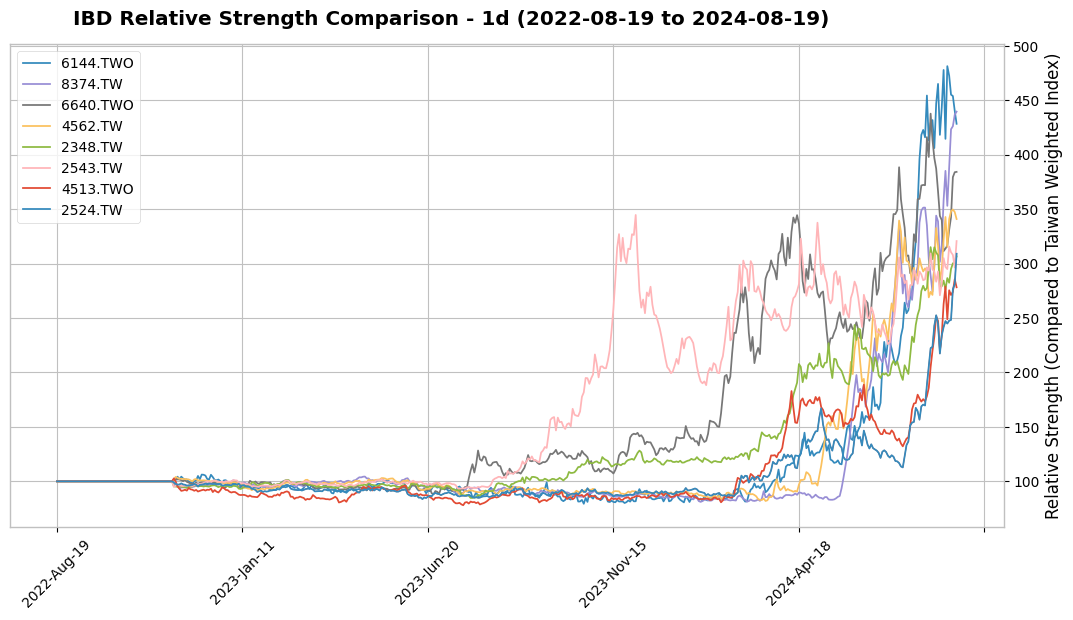

In [12]:
# @title Step 4. Show the Comparison of RS Lines {"run":"auto"}
source = "Step 3. Top Increasing RS" # @param ["Step 2. Top Percentile Items","Step 3. Top Increasing RS","Major Global Stock Indices"]
period = "2y" # @param ["1y","2y","5y"]
interval = "1d" # @param ["1d","1wk"]
backend = "mplfinance" # @param ["mplfinance","Plotly"]

import ipywidgets as widgets

def get_tickers(df):
    return [ticker for sublist in df['Tickers'] for ticker in sublist]

def convert_to_list(value):
    if isinstance(value, str):
        return value.split(',')
    return value

def tickers_from_df(df):
    tickers = OrderedSet()
    if 'Ticker' in df.columns:
        tickers += OrderedSet(df['Ticker'])
    elif 'Tickers' in df.columns:
        df['Tickers'] = df['Tickers'].apply(convert_to_list)
        tickers += OrderedSet(get_tickers(df))
    return tickers

def top_tickers():
    return tickers_from_df(df_top_s1)

def top_filtered_tickers():
    return tickers_from_df(df_top_s2)

def major_indices():
    return ['^GSPC', '^DJI', '^IXIC', '^NDX', '^RUT', '^SOX',
            '^TWII', '^N225', '^HSI',
            '^STOXX50E', '^FTSE', '^GDAXI', '^FCHI', '^GSPTSE']

tickers = {
    'Step 2. Top Percentile Items': top_tickers,
    'Step 3. Top Increasing RS': top_filtered_tickers,
    'Major Global Stock Indices': major_indices,
}[source]()

available_tickers = [tw.stock_name(t) for t in tickers]

# Create checkboxes for stock selection with the first 8 items pre-checked
checkboxes = [
    widgets.Checkbox(
        value=(i < 8),  # Set first 8 items as checked
        description=ticker,
        layout=widgets.Layout(width='auto', margin='2px')
    )
    for i, ticker in enumerate(available_tickers)
]

# Arrange checkboxes in a grid layout using GridBox
n_cols = 5  # Number of columns in the grid
n_rows = (len(checkboxes) + n_cols - 1) // n_cols  # Number of rows required

# Ensure all rows have the same number of columns
grid_items = [checkboxes[i:i + n_cols] for i in range(0, len(checkboxes), n_cols)]

# Fill any remaining cells with dummy widgets
for row in grid_items:
    while len(row) < n_cols:
        row.append(widgets.Label())  # Use Label as placeholder

# Ensure the number of rows is correct
while len(grid_items) < n_rows:
    grid_items.append([widgets.Label()] * n_cols)  # Add empty rows if necessary

# Flatten the grid_items list
flat_grid_items = [item for sublist in grid_items for item in sublist]

checkbox_grid = widgets.GridBox(flat_grid_items, layout=widgets.Layout(
    width='auto',
    grid_template_columns=f'repeat({n_cols}, 1fr)',
    grid_gap='10px'
))

# Button to confirm selection and plot
button = widgets.Button(description="Generate Plot")

# Create final layout combining grid and controls
layout = widgets.VBox([checkbox_grid, button])

# Display UI elements
display(layout)

def get_selected_stocks():
    selected_stocks = [checkbox.description for checkbox in checkboxes if checkbox.value]
    return selected_stocks

def validate_selection(selected_stocks):
    if len(selected_stocks) > 8:
        print("You can only select up to 8 stocks. Please deselect some items.")
        return selected_stocks[:8]  # Limit to 8 items
    return selected_stocks

import vistock.mpl as vs_mpl
import vistock.plotly as vs_plotly

func_dic = {
    'mplfinance': vs_mpl.ibd_rs_cmp,
    'Plotly': vs_plotly.ibd_rs_cmp,
}
ibd_rs_cmp = func_dic[backend]

if backend == 'Plotly':
    enable_plotly_in_cell()

# Define the button click event
def on_button_click(b):
    selected_stocks = get_selected_stocks()
    symbols = validate_selection(selected_stocks)
    if not symbols:
        print("No stocks selected. Please select at least one stock.")
        return
    ibd_rs_cmp.plot(symbols, interval=interval, period=period)

button.on_click(on_button_click)
